# MDSF 2018 - La suite - My solution

## First analysis and Feature Engineering

In [1]:
import io, math, requests
import pandas as pd
import operator
import numpy as np
import os
import time
from sklearn.metrics import roc_curve, auc, log_loss, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,KFold,train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns 
from collections import Counter
from hyperopt import hp,fmin, tpe, STATUS_OK, Trials
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance

In [2]:
path_X_train = "X_train.csv"
path_X_test = "X_test.csv"
path_test = "_test.csv"
X_train = pd.read_csv("X_train.csv", index_col=0, error_bad_lines=False)
test = pd.read_csv("X_test.csv", index_col=0, error_bad_lines=False)
y_train = pd.read_csv("y_train.csv", index_col=0)

train = X_train
train['y'] = y_train
n = len(train)

Skipping line 2168: expected 31 fields, saw 33
Skipping line 4822: expected 31 fields, saw 37
Skipping line 4859: expected 31 fields, saw 37
Skipping line 7342: expected 31 fields, saw 37



In [3]:
X_train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
nb_images,8880,NaN,NaN,NaN,3.63345,2.04857,0,2,3,5,29
longueur_image,8823,NaN,NaN,NaN,1807.82,1025.25,58,1000,1536,2448,5472
largeur_image,8823,NaN,NaN,NaN,1801.77,1101.21,64,970.5,1536,2448,5472
url_image,8823,8775,https://d1kvfoyrif6wzg.cloudfront.net/assets/i...,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description_produit,8880,8836,"Relié, 48 pages, couverture usagée",6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
taille,2414,33,38,402,NaN,NaN,NaN,NaN,NaN,NaN,NaN
matiere,3947,1722,Coton,144,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,120,18,4a,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
garantie,101,2,6 mois,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
annee,1497,NaN,NaN,NaN,14810.1,496237,0,1979,1998,2007,1.92019e+07


A clue was given during the challenge: consider the length of the description as a feature. Even if logically there was not so much to hope from considering the length of several other categorical variables, I also did it for them. 
I also converted categorical variables that actually had an order (like size of clothes) to make them ordered floating points.

In [4]:
for data in [train, test]:
    data['longueur_mag'] = map(lambda s: len(s.split()), data['nom_magasin'])
    data['longueur_editions'] = map(lambda s: len(s.split()) if type(s)!=float else 0, data['editions'])
    data['longueur_marque'] = map(lambda s: len(s.split()) if type(s)!=float else 0, data['marque'])
    data['longueur_auteur'] = map(lambda s: len(s.split()) if type(s)!=float else 0, data['auteur'])
    data['longueur_desc'] = map(lambda s: len(s.split()), data['description_produit'])
    data['garantie_num'] = data['garantie'].map({'3 mois':3, '6 mois':6, np.nan:0}).astype(int)
    data['etat_num'] = data['etat'].map({"en l'\xc3\xa9tat":-2, 'reconditionn\xc3\xa9':-1, np.nan:np.nan, 'bon \xc3\xa9tat':1, "comme neuf":2, "neuf":3}).astype(float)
    data['etat_presence']=data['etat_num'].map(lambda s: 0 if np.isnan(s) else 1)
    ages_possibles = list(set(data.age))
    def convert2age(s):
        if type(s)==float: return np.nan
        if s=="Naissance":return 0
        unites = 1 if s[-1]=='m' else 12
        return int(s[:-1])*unites
    data['age_num'] = data['age'].map(convert2age).astype(float)
    data['age_presence']=data['age_num'].map(lambda s: 0 if np.isnan(s) else 1)
    def convertTailleChiffre(s):
        try: a = int(s);return a
        except: return np.nan     
    def convertTailleT(s):
        try: assert(s[0]=='T');return int(s[1])
        except: return np.nan
    data['taille_chiffre'] = data['taille'].map(convertTailleChiffre).astype(float)
    data['taille_T'] = data['taille'].map(convertTailleT).astype(float)
    data['taille_SML'] = data['taille'].map({'XS':-2, 'S':-1, 'M':0, 'L':1, 'XL':2, 'XXL':3, 'XXXL':4}).astype(float)
    data['taille_presence'] = data.apply(lambda s: 0 if np.isnan(s['taille_chiffre']) and np.isnan(s['taille_T']) and np.isnan(s['taille_SML']) else 1, axis = 1)
    

Then I distinguished between numerical and categorical features. The 3 last categorical variables ('url_image', 'description_produit','nom_produit') had actually many levels, because it is unique by product. Actually a priori there was no reason to take them into account since a level which is in train data was almost never in test data, and almost only one time in train data, leaving no chance in the future cross-validation for a prediction power. However, surprisingly, it did had an impact to take them into account. The reason is that when you do LabelEncoding with Scikit Learn library, it uses behind the function numpy.unique which begins by sorting the array before returning the unique elements. So finally the levels were sorted in alphabetical order, which actually had a sense. For example, regarding the names of the products, you had the products with a word beginning by "Echarpe" that were next one to the other, or "statuette", "lot", "appareil" even if what followed each of these words was different for each product, so a decision tree-based method was able to bring something.  
I did the test of doing a random permutation of the label encodings to see how it impacted prediction and it confirmed this analysis (log-loss increased by more than 0.02). You can still exploit that to improve the way these categories are taken into account.

In [5]:
features = [a for a in  list(train.columns) if a[0]!='y']

feat_num = ['nb_images', 'longueur_image', 'largeur_image',  'annee', 'largeur_produit',
            'hauteur_produit','poids', 'prix', 'longueur_produit', 'pointure',
            'longueur_mag','longueur_editions', 'longueur_marque', 'longueur_auteur',
            'garantie_num', 'etat_num', 'age_num','taille_chiffre','taille_T', 'taille_SML',
            'taille_presence', 'age_presence', 'etat_presence']
feat_cat =  ['matiere', 'couleur',
             'wifi', 'vintage', 'marque', 'auteur', 'editions',
             'categorie', 'sous_categorie_1', 'sous_categorie_2', 'sous_categorie_3', 
             'sous_categorie_4', 'nom_magasin']
feat_cat += ['url_image', 'description_produit','nom_produit']

features = feat_num + feat_cat


Treating NaNs in a very classic way : 

In [6]:
all_data = pd.concat((train, test), sort = False)
for p in feat_num:
    median = all_data[p].median()
    all_data[p] = all_data[p].fillna(median)
    train[p] = train[p].fillna(median)
    test[p] = test[p].fillna(median)

for p in feat_cat:
    train[p] = train[p].fillna('missing')
    test[p] = test[p].fillna('missing')

Examining correlations :

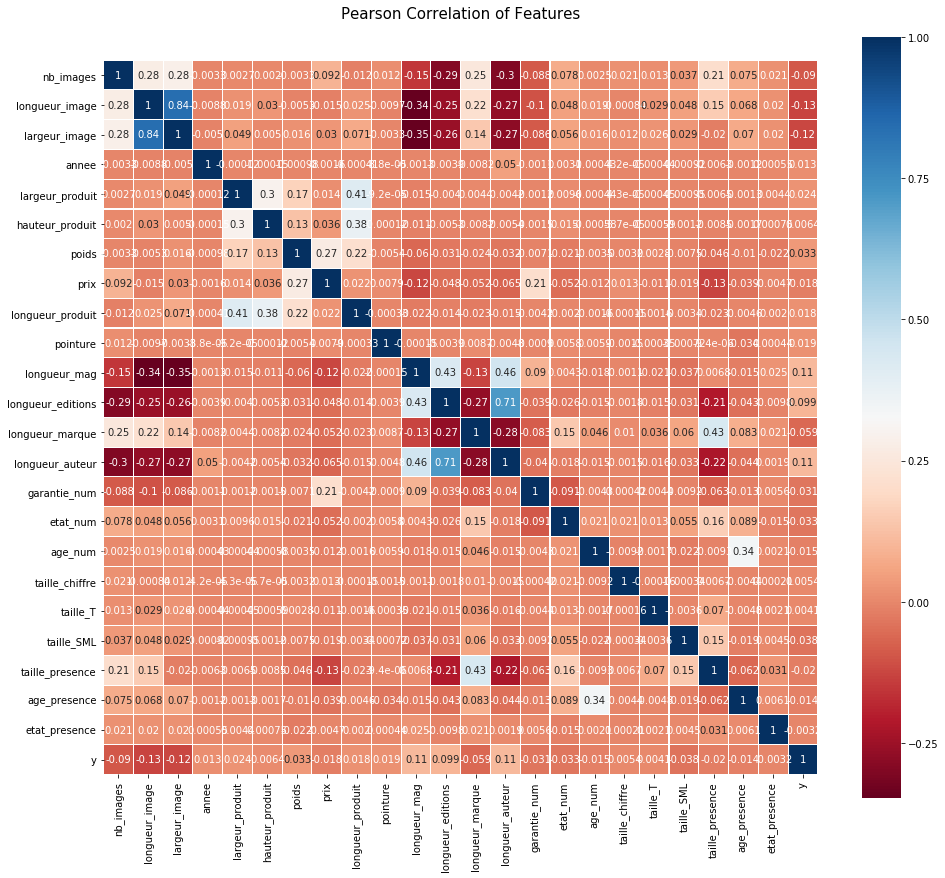

In [7]:
colormap = plt.cm.RdBu
plt.figure(figsize=(16,14))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train[feat_num + ['y']].astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

Then we examine how are distributed the levels for each categorical variable.

In [8]:
for c in feat_cat:
    ct = Counter(list(all_data[c]))
    print "CATEGORY : %s"%c
    print "number unique= %d"%len(ct.most_common(100000))
    print ct.most_common(20)
    print "\n"
    
feat_cat_and_cts  = zip(feat_cat, nb_uniques)  
feat_cats_and_cts = sorted(feat_cat_and_cts, key = lambda x: x[1])
print feat_cats_and_cts

CATEGORY : matiere
number unique= 2175
[(nan, 6588), ('Coton', 202), ('Cuir', 142), ('100% coton ', 119), ('cuir', 101), ('coton', 92), ('non renseign\xc3\xa9e ', 85), ('M\xc3\xa9tal', 70), ('Bois', 69), ('Polyester', 65), ('100% polyester ', 61), ('Laine', 59), ('100% coton', 55), ('bois', 54), ('polyester', 53), ('Soie', 51), ('m\xc3\xa9tal', 49), ('Verre', 43), ('verre', 42), ('soie', 41)]


CATEGORY : couleur
number unique= 19
[(nan, 4778), ('Multicolore', 1425), ('Noir', 1342), ('Marron', 753), ('Bleu', 639), ('Blanc', 607), ('Gris', 444), ('Rouge', 318), ('Ecru', 301), ('Argent\xc3\xa9', 219), ('Vert', 216), ('Rose', 176), ('Dor\xc3\xa9', 157), ('Orange', 143), ('Jaune', 104), ('Kaki', 87), ('Violet', 78), ('Fauve', 28), ('Taupe', 25)]


CATEGORY : wifi
number unique= 3
[(nan, 11739), (True, 78), (False, 23)]


CATEGORY : vintage
number unique= 3
[(False, 5082), (nan, 4030), (True, 2728)]


CATEGORY : marque
number unique= 3330
[(nan, 6076), ('tmp', 120), ('non renseign\xc3\xa9e 

NameError: name 'nb_uniques' is not defined

Now an important part of the code :
For the binary categorical variables, I transformed them into 1 and -1, and for missing values, I took a logivcal value between -1 and 1. (Actually because I used a decision-tree based model, the value between -1 and 1 was finally not important).
In order to deal with the other categorical variables, I did following : a categorical value which is frequent must be really taken into account (i.e.lonely) , i.e. not with Label Encoding, and scarce categorical values can be used together with Label Encoding.
For the threshold to use to decide what is a frequent categorical value, I tested different values examining the results given by a Random Forest in prediction [and not directly the Gradient Boosting because it took too times to optimize meta-parameters]. I finally used a thresold of 75 but results were not so much different for lower thresholds (but a threshold of 75 allowed me to have less features)

In [9]:
train['train'] = True
test['train'] = False
all_data = pd.concat((train, test), axis = 0, sort = False)

feat_cat_common = []
feat_cat_labelEncoded = []
threshold = 75
p = 'matiere'
for p in feat_cat:
    print p
    ct = Counter(all_data[p])
    if len(ct.most_common(100)) == 2 or (len(ct.most_common(100))==3 and 'missing' in [a[0] for a in ct.most_common(100)]):
        commons = [q for q in ct.most_common(3) if  q[0] != 'missing']
        a, ct_a  = commons[0]
        b, ct_b = commons[1]
        moy = float(ct_a - ct_b)/float(ct_a+ct_b)
        train[p + '_'+str(a)] = train[p].map({a:1, b:-1, 'missing': moy})
        test[p+'_'+str(a)] = test[p].map({a:1, b:-1, 'missing': moy})
        feat_num.append(p+'_'+str(a))
    else:
        commons = [a for a in ct.most_common(100) if a[1]>=threshold]
        words_commons = [a[0] for a in commons]
        all_data[p+'_common'] = all_data[p].map(lambda s: s if s in words_commons else 'rare')
        feat_cat_common.append(p+'_common')
        all_data[p + '_rare'] = all_data[p].map(lambda s: s if s not in words_commons else 'not_rare')
        le = LabelEncoder()
        le.fit(all_data[p+'_rare'])
        for data in [train, test]:
            data[p +  '_rare'] =  data[p].map(lambda s: s if s not in words_commons else 'not_rare')
            data[p+ '_labelEncoded'] = le.transform(data[p+ '_rare'])
        feat_cat_labelEncoded.append(p+'_labelEncoded')

matiere
couleur
wifi
vintage
marque
auteur
editions
categorie
sous_categorie_1
sous_categorie_2
sous_categorie_3
sous_categorie_4
nom_magasin
url_image
description_produit
nom_produit


Here we use get_dummies to dot the OneHotEncoding for the frequent categories. And we obtain our final features to use.

In [10]:
all_dummies = pd.get_dummies(all_data[feat_cat_common + ['train']], columns = feat_cat_common)

feat_dummies = list(all_dummies.columns)
feat_dummies.remove('train')
train_only_cats_dummies = all_dummies[all_dummies.train]
test_only_cats_dummies = all_dummies[all_dummies.train==False]

train = pd.concat((train, train_only_cats_dummies), axis = 1)
test = pd.concat((test, test_only_cats_dummies), axis = 1)

features_used = feat_num+feat_cat_labelEncoded + feat_dummies
features_used = [a for i, a in enumerate(features_used) if a not in features_used[:i]]

train[features_used].head()

,nb_images,longueur_image,largeur_image,annee,largeur_produit,hauteur_produit,poids,prix,longueur_produit,pointure,...,nom_magasin_common_Label Emmaus Angers,nom_magasin_common_Label Emmaüs Chambéry,nom_magasin_common_Label Emmaüs de Grenoble,nom_magasin_common_Le Léopard,nom_magasin_common_Tri d'Union - la boutique en ligne,nom_magasin_common_rare,url_image_common_rare,description_produit_common_rare,nom_produit_common_missing,nom_produit_common_rare
id,,,,,,,,,,,,,,,,,,,,,
0,3,3458.0,2552.0,1998.0,40.0,60.0,200.0,4.5,50.0,39.0,...,0,0,0,0,0,0,1,1,0,1
1,2,2486.0,2254.0,1998.0,40.0,60.0,1000.0,15.0,50.0,39.0,...,0,0,0,0,0,1,1,1,0,1
2,3,1536.0,1536.0,1998.0,40.0,60.0,360.0,16.0,50.0,39.0,...,0,1,0,0,0,0,1,1,1,0
3,2,1100.0,1100.0,1998.0,40.0,60.0,520.0,24.0,50.0,39.0,...,0,0,0,0,0,0,1,1,0,1
4,2,450.0,450.0,1998.0,40.0,60.0,300.0,139.0,50.0,39.0,...,0,0,0,0,0,0,1,1,0,1


## Random Forest

Then Random Forest with cross-validation was used : it is quicker to test the relevance of all the feature engineering than Gradient Boosting, and you already obtain very good results. I generally iterated ~3 times Cross-Validation to find the best max_depth and max_features, considering at the beginning larges values (like 'max_depth' : [5,12,20], 'max_features': [0.1,0.4,0.8]) and reducing the extent of the values to search (for example finally 'max_depth' : [18,19,20], 'max_features': [0.22,0.25,0.28]). The number of trees can be chosen not too big to go faster, and if you finally use Random Forest you can increase it before submission. The criterion can also be optimized between gini and entropy.

In [11]:
n_folds = 5
n_jobs = 7
rf = RandomForestClassifier(random_state = 4)
grid = {'max_depth' : [20,22], 'max_features': [0.3,0.35], 'n_estimators' : [300], 'criterion' : ['gini', 'entropy']}

cve = GridSearchCV(estimator = rf, param_grid = grid, scoring ='neg_log_loss' ,
                   cv = n_folds, n_jobs = n_jobs, verbose = 10)

t0 = time.time()
cve.fit(train[features_used],train['y'])
print time.time() - t0
rf = cve.best_estimator_
grid_scores = cve.grid_scores_
print grid_scores
print rf
print cve.best_score_

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] max_features=0.3, n_estimators=300, criterion=gini, max_depth=20 
[CV] max_features=0.3, n_estimators=300, criterion=gini, max_depth=20 
[CV] max_features=0.3, n_estimators=300, criterion=gini, max_depth=20 
[CV] max_features=0.3, n_estimators=300, criterion=gini, max_depth=20 
[CV] max_features=0.3, n_estimators=300, criterion=gini, max_depth=20 
[CV] max_features=0.35, n_estimators=300, criterion=gini, max_depth=20 
[CV] max_features=0.35, n_estimators=300, criterion=gini, max_depth=20 
[CV]  max_features=0.3, n_estimators=300, criterion=gini, max_depth=20, score=-0.931287033967, total=  20.6s
[CV] max_features=0.35, n_estimators=300, criterion=gini, max_depth=20 
[CV]  max_features=0.3, n_estimators=300, criterion=gini, max_depth=20, score=-0.889273481436, total=  20.9s
[CV] max_features=0.35, n_estimators=300, criterion=gini, max_depth=20 
[CV]  max_features=0.3, n_estimators=300, criterion=gini, max_depth=20, score=-

[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:   22.3s


[CV]  max_features=0.3, n_estimators=300, criterion=gini, max_depth=20, score=-0.906781837382, total=  21.6s
[CV] max_features=0.3, n_estimators=300, criterion=gini, max_depth=22 
[CV]  max_features=0.35, n_estimators=300, criterion=gini, max_depth=20, score=-0.928148088348, total=  23.5s
[CV] max_features=0.3, n_estimators=300, criterion=gini, max_depth=22 
[CV]  max_features=0.35, n_estimators=300, criterion=gini, max_depth=20, score=-0.891928105497, total=  24.3s
[CV] max_features=0.3, n_estimators=300, criterion=gini, max_depth=22 
[CV]  max_features=0.3, n_estimators=300, criterion=gini, max_depth=22, score=-0.89370156675, total=  20.0s
[CV] max_features=0.3, n_estimators=300, criterion=gini, max_depth=22 
[CV]  max_features=0.3, n_estimators=300, criterion=gini, max_depth=22, score=-0.930133992863, total=  20.8s
[CV] max_features=0.35, n_estimators=300, criterion=gini, max_depth=22 
[CV]  max_features=0.35, n_estimators=300, criterion=gini, max_depth=20, score=-0.923006631161, to

[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed:   45.3s


[CV]  max_features=0.3, n_estimators=300, criterion=gini, max_depth=22, score=-0.923701816408, total=  20.3s
[CV] max_features=0.35, n_estimators=300, criterion=gini, max_depth=22 
[CV]  max_features=0.3, n_estimators=300, criterion=gini, max_depth=22, score=-0.910856604152, total=  20.9s
[CV] max_features=0.3, n_estimators=300, criterion=entropy, max_depth=20 
[CV]  max_features=0.3, n_estimators=300, criterion=gini, max_depth=22, score=-0.918581867621, total=  20.7s
[CV] max_features=0.3, n_estimators=300, criterion=entropy, max_depth=20 
[CV]  max_features=0.35, n_estimators=300, criterion=gini, max_depth=22, score=-0.891391967162, total=  23.4s
[CV] max_features=0.3, n_estimators=300, criterion=entropy, max_depth=20 
[CV]  max_features=0.35, n_estimators=300, criterion=gini, max_depth=22, score=-0.923874656798, total=  22.9s
[CV] max_features=0.3, n_estimators=300, criterion=entropy, max_depth=20 
[CV]  max_features=0.35, n_estimators=300, criterion=gini, max_depth=22, score=-0.906

[Parallel(n_jobs=7)]: Done  18 tasks      | elapsed:  1.2min


[CV]  max_features=0.35, n_estimators=300, criterion=gini, max_depth=22, score=-0.927021564726, total=  23.6s
[CV] max_features=0.35, n_estimators=300, criterion=entropy, max_depth=20 
[CV]  max_features=0.35, n_estimators=300, criterion=gini, max_depth=22, score=-0.899357162558, total=  23.2s
[CV] max_features=0.35, n_estimators=300, criterion=entropy, max_depth=20 
[CV]  max_features=0.3, n_estimators=300, criterion=entropy, max_depth=20, score=-0.892691774315, total=  29.9s
[CV] max_features=0.35, n_estimators=300, criterion=entropy, max_depth=20 
[CV]  max_features=0.3, n_estimators=300, criterion=entropy, max_depth=20, score=-0.925269790139, total=  27.7s
[CV] max_features=0.35, n_estimators=300, criterion=entropy, max_depth=20 
[CV]  max_features=0.3, n_estimators=300, criterion=entropy, max_depth=20, score=-0.918680729427, total=  26.0s
[CV] max_features=0.35, n_estimators=300, criterion=entropy, max_depth=20 
[CV]  max_features=0.3, n_estimators=300, criterion=entropy, max_dept

[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:  1.7min


[CV]  max_features=0.35, n_estimators=300, criterion=entropy, max_depth=20, score=-0.922229343086, total=  32.9s
[CV] max_features=0.3, n_estimators=300, criterion=entropy, max_depth=22 
[CV]  max_features=0.35, n_estimators=300, criterion=entropy, max_depth=20, score=-0.911316881261, total=  33.2s
[CV] max_features=0.35, n_estimators=300, criterion=entropy, max_depth=22 
[CV]  max_features=0.3, n_estimators=300, criterion=entropy, max_depth=22, score=-0.923221006186, total=  29.8s
[CV] max_features=0.35, n_estimators=300, criterion=entropy, max_depth=22 
[CV]  max_features=0.3, n_estimators=300, criterion=entropy, max_depth=22, score=-0.886429865245, total=  29.9s
[CV] max_features=0.35, n_estimators=300, criterion=entropy, max_depth=22 
[CV]  max_features=0.35, n_estimators=300, criterion=entropy, max_depth=20, score=-0.919321370505, total=  33.9s
[CV] max_features=0.35, n_estimators=300, criterion=entropy, max_depth=22 


[Parallel(n_jobs=7)]: Done  32 out of  40 | elapsed:  2.2min remaining:   32.7s


[CV]  max_features=0.3, n_estimators=300, criterion=entropy, max_depth=22, score=-0.920615853219, total=  29.9s
[CV] max_features=0.35, n_estimators=300, criterion=entropy, max_depth=22 
[CV]  max_features=0.3, n_estimators=300, criterion=entropy, max_depth=22, score=-0.908085590191, total=  29.9s
[CV]  max_features=0.3, n_estimators=300, criterion=entropy, max_depth=22, score=-0.916491128034, total=  29.5s
[CV]  max_features=0.35, n_estimators=300, criterion=entropy, max_depth=22, score=-0.888523020355, total=  25.9s
[CV]  max_features=0.35, n_estimators=300, criterion=entropy, max_depth=22, score=-0.908971575635, total=  25.0s


[Parallel(n_jobs=7)]: Done  37 out of  40 | elapsed:  2.6min remaining:   12.7s


[CV]  max_features=0.35, n_estimators=300, criterion=entropy, max_depth=22, score=-0.925911616895, total=  30.1s
[CV]  max_features=0.35, n_estimators=300, criterion=entropy, max_depth=22, score=-0.923209383163, total=  30.3s
[CV]  max_features=0.35, n_estimators=300, criterion=entropy, max_depth=22, score=-0.913756956692, total=  26.0s


[Parallel(n_jobs=7)]: Done  40 out of  40 | elapsed:  2.7min finished


174.073935986
[mean: -0.91067, std: 0.01469, params: {'max_features': 0.3, 'n_estimators': 300, 'criterion': 'gini', 'max_depth': 20}, mean: -0.91393, std: 0.01255, params: {'max_features': 0.35, 'n_estimators': 300, 'criterion': 'gini', 'max_depth': 20}, mean: -0.91539, std: 0.01255, params: {'max_features': 0.3, 'n_estimators': 300, 'criterion': 'gini', 'max_depth': 22}, mean: -0.90970, std: 0.01379, params: {'max_features': 0.35, 'n_estimators': 300, 'criterion': 'gini', 'max_depth': 22}, mean: -0.91386, std: 0.01189, params: {'max_features': 0.3, 'n_estimators': 300, 'criterion': 'entropy', 'max_depth': 20}, mean: -0.91484, std: 0.01259, params: {'max_features': 0.35, 'n_estimators': 300, 'criterion': 'entropy', 'max_depth': 20}, mean: -0.91097, std: 0.01330, params: {'max_features': 0.3, 'n_estimators': 300, 'criterion': 'entropy', 'max_depth': 22}, mean: -0.91207, std: 0.01329, params: {'max_features': 0.35, 'n_estimators': 300, 'criterion': 'entropy', 'max_depth': 22}]
RandomFor

/home/jbotbol/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Plotting results of each Cross-validation like following is a good way to quickly see the direction to follow. In the above example, I didn't test many combinations, but when you do it, it is still more useful.

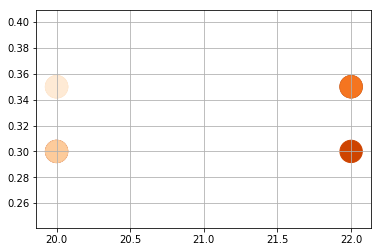

In [12]:
depths = [a[0]['max_depth'] for a in grid_scores]
max_features = [a[0]['max_features'] for a in grid_scores]
y = [np.exp(a[1]) for a in grid_scores]

plt.scatter(depths, max_features, c=y, s=500, cmap = 'Oranges')
plt.grid()
plt.show()

Then the final submission if you use Random Forest.

In [13]:
params = rf.get_params()
rf = RandomForestClassifier(n_estimators = 2000, max_depth = params['max_depth'],
                            max_features = params['max_features'], 
                            criterion = params['criterion'], n_jobs = -1)
print rf
rf.fit(train[features_used],train['y'])
y_test_pred = rf.predict_proba(test[features_used])
#submit

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=22, max_features=0.35, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


## Gradient Boosting

For Gradient Boosting, I used xgboost with 5 folds, considering for each try of hyperparameters the average log-loss score. To optimize them, I used hyperopt which is supposed to do a smart research of hyperparameters starting with the given distributions (prior dist.) and taking into account histories of scores to go to good direction updating the posterior dist. after each try (I didn't take the time to dive into the details, but it should be better than Random Search :-)). 

Early stopping allows the model to stop adding trees when it stops improving the score on validation set after a few iterations (that you can set). Then you find the optimal number of trees to choose for the final model trained on all the data.

Finally, because a learning rate of 0.01 is low, and training is long, you can begin with a learning rate of 0.1, with a large distribution for the hyperparameters, and then do a second pass where you shorten the dist. and use a learning rate of 0.01 (which gives better performance). Here I commented examples of distributions, and wrote the final hyperparameters I used.

In [14]:
n_folds =  5
kf = KFold(n_folds, shuffle = True) 
indices_kf = [(p[0], p[1]) for p in kf.split(range(n))]
def loss(est, X, y):
    preds = est.predict_proba(np.array(X))
    return log_loss(y, preds)

early_stopping_around = 50
n_jobs = 7
nb_evaluations_hyperopt = 1
gb = XGBClassifier()


dico_res_gb = dict()
def scoreGB(params):
    print "params : %s"%str(params)
    for q in params:
        v =  params[q]
        if type(v)==float and int(v)==v:
            params[q] = int(v)
    gb  =  XGBClassifier(**params)
    scores_test_gb = []; scores_train_gb= []; lengths = []
    for indices_train, indices_test in indices_kf:
        eval_set = [(np.array(train.loc[indices_train,features_used]),np.array(train.loc[indices_train, 'y'])),
                (np.array(train.loc[indices_test,features_used]),np.array(train.loc[indices_test, 'y']))]
        gb.fit(np.array(train.loc[indices_train,features_used]),np.array(train.loc[indices_train, 'y']),
                eval_metric=['mlogloss'], eval_set = eval_set, 
                early_stopping_rounds= early_stopping_around, verbose=1)
        score_train_gb = loss(gb,train.loc[indices_train,features_used],train.loc[indices_train, 'y'] )
        score_test_gb = loss(gb,train.loc[indices_test,features_used],(train.loc[indices_test, 'y']) )
        scores_train_gb.append(score_train_gb)
        scores_test_gb.append(score_test_gb)
        length = len(gb.evals_result()['validation_1']['mlogloss'])
        lengths.append(length)
        print " Score on Train Set : %.4f, Score on Test Set : %.4f"%(score_train_gb, score_test_gb)
    length_mean = int(np.mean(lengths))
    score_test_avg_gb = np.mean(scores_test_gb)
    dico_res_gb[tuple(params.items() + [('n_estimators',length_mean - early_stopping_around)])] = score_test_avg_gb
    
    print "AVG TEST Score : %.4f"%score_test_avg_gb
    return {"loss": score_test_avg_gb, "status": STATUS_OK}


def optimizeGB():
#    space = {
#            'objective':'multi:softprob',
#             'n_estimators' : 2000,
#             'learning_rate' : 0.01,
#             'max_depth' : hp.quniform('max_depth', 3, 18, 1),
#             'min_child_weight' : hp.quniform('min_child_weight', 1, 20, 1),
#             'subsample' : hp.quniform('subsample', 0.6, 1, 0.05),
#             'gamma' : hp.quniform('gamma', 0,0.1,0.01),
#             'colsample_bytree' : hp.quniform('colsample_bytree', 0.2, 0.25, 0.01),
#             'silent' : True,
#             'nthread' : n_jobs
#             }
    space = {
            'objective':'multi:softprob',
             'n_estimators' : 2000,
             'learning_rate' : 0.01,
             'max_depth' : 15,
             'min_child_weight' : 6.15,
             'subsample' : 0.95,
             'gamma' : 0.073,
             'colsample_bytree' :0.23,
             'silent' : True,
             'nthread' : n_jobs
             }

    best = fmin(scoreGB, space, algo=tpe.suggest, max_evals=nb_evaluations_hyperopt)

    print best

In [15]:
t0 = time.time()
optimizeGB()
print time.time() - t0
best_ones = sorted(dico_res_gb.items(), key=operator.itemgetter(1), reverse = False)[:5]
print best_ones
best_pars = best_ones[0]
best_score = best_pars[1]
best_pars = best_pars[0]
best_pars = dict(best_pars)


params : {'colsample_bytree': 0.23, 'silent': True, 'learning_rate': 0.01, 'nthread': 7, 'min_child_weight': 6.15, 'n_estimators': 2000, 'subsample': 0.95, 'objective': 'multi:softprob', 'max_depth': 15, 'gamma': 0.073}
[0]	validation_0-mlogloss:1.09694	validation_1-mlogloss:1.0977
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 50 rounds.
[1]	validation_0-mlogloss:1.09438	validation_1-mlogloss:1.09619
[2]	validation_0-mlogloss:1.09192	validation_1-mlogloss:1.09485
[3]	validation_0-mlogloss:1.0901	validation_1-mlogloss:1.09365
[4]	validation_0-mlogloss:1.08729	validation_1-mlogloss:1.09228
[5]	validation_0-mlogloss:1.08375	validation_1-mlogloss:1.09018
[6]	validation_0-mlogloss:1.08163	validation_1-mlogloss:1.08909
[7]	validation_0-mlogloss:1.07926	validation_1-mlogloss:1.08767
[8]	validation_0-mlogloss:1.07656	validation_1-mlogloss:1.08628
[9]	validation_0-mlogloss:1.07337	valid

[119]	validation_0-mlogloss:0.873676	validation_1-mlogloss:0.99094
[120]	validation_0-mlogloss:0.872563	validation_1-mlogloss:0.990466
[121]	validation_0-mlogloss:0.870935	validation_1-mlogloss:0.989931
[122]	validation_0-mlogloss:0.869708	validation_1-mlogloss:0.989507
[123]	validation_0-mlogloss:0.868693	validation_1-mlogloss:0.988964
[124]	validation_0-mlogloss:0.867565	validation_1-mlogloss:0.988597
[125]	validation_0-mlogloss:0.866197	validation_1-mlogloss:0.988176
[126]	validation_0-mlogloss:0.865055	validation_1-mlogloss:0.987711
[127]	validation_0-mlogloss:0.864045	validation_1-mlogloss:0.987291
[128]	validation_0-mlogloss:0.862972	validation_1-mlogloss:0.987034
[129]	validation_0-mlogloss:0.861562	validation_1-mlogloss:0.986586
[130]	validation_0-mlogloss:0.860432	validation_1-mlogloss:0.986158
[131]	validation_0-mlogloss:0.859291	validation_1-mlogloss:0.985542
[132]	validation_0-mlogloss:0.858195	validation_1-mlogloss:0.985115
[133]	validation_0-mlogloss:0.85727	validation_1-

[240]	validation_0-mlogloss:0.749093	validation_1-mlogloss:0.944638
[241]	validation_0-mlogloss:0.748264	validation_1-mlogloss:0.944429
[242]	validation_0-mlogloss:0.747249	validation_1-mlogloss:0.944294
[243]	validation_0-mlogloss:0.746167	validation_1-mlogloss:0.943875
[244]	validation_0-mlogloss:0.745538	validation_1-mlogloss:0.943674
[245]	validation_0-mlogloss:0.744796	validation_1-mlogloss:0.943501
[246]	validation_0-mlogloss:0.744252	validation_1-mlogloss:0.943343
[247]	validation_0-mlogloss:0.743411	validation_1-mlogloss:0.943008
[248]	validation_0-mlogloss:0.742643	validation_1-mlogloss:0.942722
[249]	validation_0-mlogloss:0.741929	validation_1-mlogloss:0.942526
[250]	validation_0-mlogloss:0.741376	validation_1-mlogloss:0.942321
[251]	validation_0-mlogloss:0.740738	validation_1-mlogloss:0.942009
[252]	validation_0-mlogloss:0.740055	validation_1-mlogloss:0.941729
[253]	validation_0-mlogloss:0.739372	validation_1-mlogloss:0.941574
[254]	validation_0-mlogloss:0.738301	validation_

[361]	validation_0-mlogloss:0.672312	validation_1-mlogloss:0.922673
[362]	validation_0-mlogloss:0.671784	validation_1-mlogloss:0.922627
[363]	validation_0-mlogloss:0.671184	validation_1-mlogloss:0.922477
[364]	validation_0-mlogloss:0.670853	validation_1-mlogloss:0.922368
[365]	validation_0-mlogloss:0.670136	validation_1-mlogloss:0.922203
[366]	validation_0-mlogloss:0.669595	validation_1-mlogloss:0.922075
[367]	validation_0-mlogloss:0.669233	validation_1-mlogloss:0.921987
[368]	validation_0-mlogloss:0.668754	validation_1-mlogloss:0.921829
[369]	validation_0-mlogloss:0.668532	validation_1-mlogloss:0.921775
[370]	validation_0-mlogloss:0.667993	validation_1-mlogloss:0.92153
[371]	validation_0-mlogloss:0.667799	validation_1-mlogloss:0.921451
[372]	validation_0-mlogloss:0.667197	validation_1-mlogloss:0.921189
[373]	validation_0-mlogloss:0.66664	validation_1-mlogloss:0.921097
[374]	validation_0-mlogloss:0.665962	validation_1-mlogloss:0.920997
[375]	validation_0-mlogloss:0.66534	validation_1-m

[483]	validation_0-mlogloss:0.616323	validation_1-mlogloss:0.909783
[484]	validation_0-mlogloss:0.616083	validation_1-mlogloss:0.909734
[485]	validation_0-mlogloss:0.615753	validation_1-mlogloss:0.909733
[486]	validation_0-mlogloss:0.61545	validation_1-mlogloss:0.909734
[487]	validation_0-mlogloss:0.615146	validation_1-mlogloss:0.909727
[488]	validation_0-mlogloss:0.614695	validation_1-mlogloss:0.9096
[489]	validation_0-mlogloss:0.614385	validation_1-mlogloss:0.909505
[490]	validation_0-mlogloss:0.614237	validation_1-mlogloss:0.909482
[491]	validation_0-mlogloss:0.613839	validation_1-mlogloss:0.909454
[492]	validation_0-mlogloss:0.613525	validation_1-mlogloss:0.909392
[493]	validation_0-mlogloss:0.613111	validation_1-mlogloss:0.909328
[494]	validation_0-mlogloss:0.612634	validation_1-mlogloss:0.909198
[495]	validation_0-mlogloss:0.61232	validation_1-mlogloss:0.909152
[496]	validation_0-mlogloss:0.611773	validation_1-mlogloss:0.909065
[497]	validation_0-mlogloss:0.611372	validation_1-ml

[604]	validation_0-mlogloss:0.573978	validation_1-mlogloss:0.90292
[605]	validation_0-mlogloss:0.573716	validation_1-mlogloss:0.902871
[606]	validation_0-mlogloss:0.573418	validation_1-mlogloss:0.902744
[607]	validation_0-mlogloss:0.573016	validation_1-mlogloss:0.902677
[608]	validation_0-mlogloss:0.572734	validation_1-mlogloss:0.902608
[609]	validation_0-mlogloss:0.572394	validation_1-mlogloss:0.902574
[610]	validation_0-mlogloss:0.571989	validation_1-mlogloss:0.902451
[611]	validation_0-mlogloss:0.571615	validation_1-mlogloss:0.902389
[612]	validation_0-mlogloss:0.57137	validation_1-mlogloss:0.902342
[613]	validation_0-mlogloss:0.571193	validation_1-mlogloss:0.902281
[614]	validation_0-mlogloss:0.5707	validation_1-mlogloss:0.902283
[615]	validation_0-mlogloss:0.570408	validation_1-mlogloss:0.902255
[616]	validation_0-mlogloss:0.570096	validation_1-mlogloss:0.902212
[617]	validation_0-mlogloss:0.569905	validation_1-mlogloss:0.90219
[618]	validation_0-mlogloss:0.569652	validation_1-mlo

[725]	validation_0-mlogloss:0.539768	validation_1-mlogloss:0.898754
[726]	validation_0-mlogloss:0.539503	validation_1-mlogloss:0.898733
[727]	validation_0-mlogloss:0.539048	validation_1-mlogloss:0.898645
[728]	validation_0-mlogloss:0.538762	validation_1-mlogloss:0.898549
[729]	validation_0-mlogloss:0.538434	validation_1-mlogloss:0.898511
[730]	validation_0-mlogloss:0.538057	validation_1-mlogloss:0.898497
[731]	validation_0-mlogloss:0.53784	validation_1-mlogloss:0.898455
[732]	validation_0-mlogloss:0.537347	validation_1-mlogloss:0.898359
[733]	validation_0-mlogloss:0.537061	validation_1-mlogloss:0.898319
[734]	validation_0-mlogloss:0.536779	validation_1-mlogloss:0.898305
[735]	validation_0-mlogloss:0.536543	validation_1-mlogloss:0.898327
[736]	validation_0-mlogloss:0.536305	validation_1-mlogloss:0.898312
[737]	validation_0-mlogloss:0.536109	validation_1-mlogloss:0.898339
[738]	validation_0-mlogloss:0.535835	validation_1-mlogloss:0.898298
[739]	validation_0-mlogloss:0.535497	validation_1

[846]	validation_0-mlogloss:0.511193	validation_1-mlogloss:0.896365
[847]	validation_0-mlogloss:0.511072	validation_1-mlogloss:0.896379
[848]	validation_0-mlogloss:0.51075	validation_1-mlogloss:0.896387
[849]	validation_0-mlogloss:0.51058	validation_1-mlogloss:0.896393
[850]	validation_0-mlogloss:0.510348	validation_1-mlogloss:0.896455
[851]	validation_0-mlogloss:0.510096	validation_1-mlogloss:0.896389
[852]	validation_0-mlogloss:0.509845	validation_1-mlogloss:0.896373
[853]	validation_0-mlogloss:0.509675	validation_1-mlogloss:0.896395
[854]	validation_0-mlogloss:0.509501	validation_1-mlogloss:0.896366
[855]	validation_0-mlogloss:0.509262	validation_1-mlogloss:0.896347
[856]	validation_0-mlogloss:0.508996	validation_1-mlogloss:0.896358
[857]	validation_0-mlogloss:0.508744	validation_1-mlogloss:0.896341
[858]	validation_0-mlogloss:0.508531	validation_1-mlogloss:0.896347
[859]	validation_0-mlogloss:0.50831	validation_1-mlogloss:0.896322
[860]	validation_0-mlogloss:0.508167	validation_1-m

[967]	validation_0-mlogloss:0.484377	validation_1-mlogloss:0.89499
[968]	validation_0-mlogloss:0.484252	validation_1-mlogloss:0.894965
[969]	validation_0-mlogloss:0.483996	validation_1-mlogloss:0.894969
[970]	validation_0-mlogloss:0.483874	validation_1-mlogloss:0.894974
[971]	validation_0-mlogloss:0.483663	validation_1-mlogloss:0.894961
[972]	validation_0-mlogloss:0.483546	validation_1-mlogloss:0.894936
[973]	validation_0-mlogloss:0.483272	validation_1-mlogloss:0.894951
[974]	validation_0-mlogloss:0.482953	validation_1-mlogloss:0.894881
[975]	validation_0-mlogloss:0.482868	validation_1-mlogloss:0.894877
[976]	validation_0-mlogloss:0.482617	validation_1-mlogloss:0.894875
[977]	validation_0-mlogloss:0.482345	validation_1-mlogloss:0.894863
[978]	validation_0-mlogloss:0.482027	validation_1-mlogloss:0.894827
[979]	validation_0-mlogloss:0.481964	validation_1-mlogloss:0.894848
[980]	validation_0-mlogloss:0.481862	validation_1-mlogloss:0.894849
[981]	validation_0-mlogloss:0.481554	validation_1

[1087]	validation_0-mlogloss:0.458817	validation_1-mlogloss:0.894403
[1088]	validation_0-mlogloss:0.458655	validation_1-mlogloss:0.894376
[1089]	validation_0-mlogloss:0.458464	validation_1-mlogloss:0.89438
[1090]	validation_0-mlogloss:0.458334	validation_1-mlogloss:0.894398
[1091]	validation_0-mlogloss:0.458195	validation_1-mlogloss:0.894367
[1092]	validation_0-mlogloss:0.458075	validation_1-mlogloss:0.894318
[1093]	validation_0-mlogloss:0.457964	validation_1-mlogloss:0.89436
[1094]	validation_0-mlogloss:0.457703	validation_1-mlogloss:0.894344
[1095]	validation_0-mlogloss:0.457569	validation_1-mlogloss:0.894374
[1096]	validation_0-mlogloss:0.457424	validation_1-mlogloss:0.894427
[1097]	validation_0-mlogloss:0.457326	validation_1-mlogloss:0.894431
[1098]	validation_0-mlogloss:0.4572	validation_1-mlogloss:0.894463
[1099]	validation_0-mlogloss:0.45695	validation_1-mlogloss:0.894502
[1100]	validation_0-mlogloss:0.456731	validation_1-mlogloss:0.894521
[1101]	validation_0-mlogloss:0.45644	va

[95]	validation_0-mlogloss:0.905011	validation_1-mlogloss:1.01029
[96]	validation_0-mlogloss:0.903587	validation_1-mlogloss:1.00965
[97]	validation_0-mlogloss:0.902253	validation_1-mlogloss:1.00903
[98]	validation_0-mlogloss:0.900571	validation_1-mlogloss:1.00821
[99]	validation_0-mlogloss:0.899485	validation_1-mlogloss:1.00777
[100]	validation_0-mlogloss:0.898487	validation_1-mlogloss:1.00727
[101]	validation_0-mlogloss:0.896855	validation_1-mlogloss:1.00666
[102]	validation_0-mlogloss:0.895601	validation_1-mlogloss:1.00607
[103]	validation_0-mlogloss:0.894626	validation_1-mlogloss:1.00568
[104]	validation_0-mlogloss:0.893117	validation_1-mlogloss:1.00509
[105]	validation_0-mlogloss:0.891255	validation_1-mlogloss:1.00443
[106]	validation_0-mlogloss:0.88939	validation_1-mlogloss:1.00353
[107]	validation_0-mlogloss:0.888514	validation_1-mlogloss:1.00323
[108]	validation_0-mlogloss:0.887101	validation_1-mlogloss:1.00269
[109]	validation_0-mlogloss:0.885702	validation_1-mlogloss:1.00221
[

[217]	validation_0-mlogloss:0.76686	validation_1-mlogloss:0.960416
[218]	validation_0-mlogloss:0.765324	validation_1-mlogloss:0.960048
[219]	validation_0-mlogloss:0.764397	validation_1-mlogloss:0.959794
[220]	validation_0-mlogloss:0.763162	validation_1-mlogloss:0.959307
[221]	validation_0-mlogloss:0.762146	validation_1-mlogloss:0.95913
[222]	validation_0-mlogloss:0.761111	validation_1-mlogloss:0.958816
[223]	validation_0-mlogloss:0.760544	validation_1-mlogloss:0.958661
[224]	validation_0-mlogloss:0.759761	validation_1-mlogloss:0.95853
[225]	validation_0-mlogloss:0.758958	validation_1-mlogloss:0.958294
[226]	validation_0-mlogloss:0.757657	validation_1-mlogloss:0.957757
[227]	validation_0-mlogloss:0.756721	validation_1-mlogloss:0.957584
[228]	validation_0-mlogloss:0.755769	validation_1-mlogloss:0.957311
[229]	validation_0-mlogloss:0.754869	validation_1-mlogloss:0.956982
[230]	validation_0-mlogloss:0.75402	validation_1-mlogloss:0.956729
[231]	validation_0-mlogloss:0.753297	validation_1-ml

[338]	validation_0-mlogloss:0.681093	validation_1-mlogloss:0.935875
[339]	validation_0-mlogloss:0.680485	validation_1-mlogloss:0.935841
[340]	validation_0-mlogloss:0.679789	validation_1-mlogloss:0.935752
[341]	validation_0-mlogloss:0.679179	validation_1-mlogloss:0.935649
[342]	validation_0-mlogloss:0.678505	validation_1-mlogloss:0.93552
[343]	validation_0-mlogloss:0.677779	validation_1-mlogloss:0.935414
[344]	validation_0-mlogloss:0.677168	validation_1-mlogloss:0.935309
[345]	validation_0-mlogloss:0.676757	validation_1-mlogloss:0.935233
[346]	validation_0-mlogloss:0.67634	validation_1-mlogloss:0.935095
[347]	validation_0-mlogloss:0.675844	validation_1-mlogloss:0.935063
[348]	validation_0-mlogloss:0.675223	validation_1-mlogloss:0.93485
[349]	validation_0-mlogloss:0.67457	validation_1-mlogloss:0.934753
[350]	validation_0-mlogloss:0.674072	validation_1-mlogloss:0.934583
[351]	validation_0-mlogloss:0.673525	validation_1-mlogloss:0.93455
[352]	validation_0-mlogloss:0.67275	validation_1-mlog

[459]	validation_0-mlogloss:0.621777	validation_1-mlogloss:0.923377
[460]	validation_0-mlogloss:0.621248	validation_1-mlogloss:0.923289
[461]	validation_0-mlogloss:0.620782	validation_1-mlogloss:0.923277
[462]	validation_0-mlogloss:0.620218	validation_1-mlogloss:0.923144
[463]	validation_0-mlogloss:0.619743	validation_1-mlogloss:0.923024
[464]	validation_0-mlogloss:0.619463	validation_1-mlogloss:0.923013
[465]	validation_0-mlogloss:0.619044	validation_1-mlogloss:0.922957
[466]	validation_0-mlogloss:0.618285	validation_1-mlogloss:0.922948
[467]	validation_0-mlogloss:0.61784	validation_1-mlogloss:0.922911
[468]	validation_0-mlogloss:0.617489	validation_1-mlogloss:0.922762
[469]	validation_0-mlogloss:0.617192	validation_1-mlogloss:0.922746
[470]	validation_0-mlogloss:0.616789	validation_1-mlogloss:0.922674
[471]	validation_0-mlogloss:0.616544	validation_1-mlogloss:0.922643
[472]	validation_0-mlogloss:0.616073	validation_1-mlogloss:0.922593
[473]	validation_0-mlogloss:0.615773	validation_1

[580]	validation_0-mlogloss:0.575166	validation_1-mlogloss:0.916453
[581]	validation_0-mlogloss:0.574842	validation_1-mlogloss:0.916423
[582]	validation_0-mlogloss:0.574479	validation_1-mlogloss:0.916409
[583]	validation_0-mlogloss:0.574272	validation_1-mlogloss:0.916372
[584]	validation_0-mlogloss:0.573951	validation_1-mlogloss:0.916325
[585]	validation_0-mlogloss:0.573731	validation_1-mlogloss:0.916271
[586]	validation_0-mlogloss:0.573263	validation_1-mlogloss:0.91621
[587]	validation_0-mlogloss:0.572801	validation_1-mlogloss:0.916132
[588]	validation_0-mlogloss:0.572517	validation_1-mlogloss:0.916106
[589]	validation_0-mlogloss:0.572197	validation_1-mlogloss:0.916056
[590]	validation_0-mlogloss:0.571886	validation_1-mlogloss:0.916047
[591]	validation_0-mlogloss:0.571634	validation_1-mlogloss:0.915937
[592]	validation_0-mlogloss:0.571289	validation_1-mlogloss:0.915959
[593]	validation_0-mlogloss:0.571069	validation_1-mlogloss:0.915948
[594]	validation_0-mlogloss:0.570642	validation_1

[701]	validation_0-mlogloss:0.539133	validation_1-mlogloss:0.912142
[702]	validation_0-mlogloss:0.538857	validation_1-mlogloss:0.912119
[703]	validation_0-mlogloss:0.538501	validation_1-mlogloss:0.91209
[704]	validation_0-mlogloss:0.538178	validation_1-mlogloss:0.912069
[705]	validation_0-mlogloss:0.538	validation_1-mlogloss:0.912019
[706]	validation_0-mlogloss:0.537673	validation_1-mlogloss:0.911954
[707]	validation_0-mlogloss:0.53737	validation_1-mlogloss:0.911922
[708]	validation_0-mlogloss:0.537249	validation_1-mlogloss:0.911903
[709]	validation_0-mlogloss:0.536956	validation_1-mlogloss:0.91191
[710]	validation_0-mlogloss:0.53673	validation_1-mlogloss:0.911897
[711]	validation_0-mlogloss:0.536424	validation_1-mlogloss:0.911911
[712]	validation_0-mlogloss:0.536102	validation_1-mlogloss:0.911841
[713]	validation_0-mlogloss:0.535785	validation_1-mlogloss:0.911829
[714]	validation_0-mlogloss:0.535513	validation_1-mlogloss:0.91178
[715]	validation_0-mlogloss:0.535317	validation_1-mloglo

[822]	validation_0-mlogloss:0.507921	validation_1-mlogloss:0.909479
[823]	validation_0-mlogloss:0.507672	validation_1-mlogloss:0.909484
[824]	validation_0-mlogloss:0.507436	validation_1-mlogloss:0.909438
[825]	validation_0-mlogloss:0.5073	validation_1-mlogloss:0.909402
[826]	validation_0-mlogloss:0.507094	validation_1-mlogloss:0.909358
[827]	validation_0-mlogloss:0.50685	validation_1-mlogloss:0.90937
[828]	validation_0-mlogloss:0.506626	validation_1-mlogloss:0.909328
[829]	validation_0-mlogloss:0.506484	validation_1-mlogloss:0.909311
[830]	validation_0-mlogloss:0.506202	validation_1-mlogloss:0.909321
[831]	validation_0-mlogloss:0.506036	validation_1-mlogloss:0.909266
[832]	validation_0-mlogloss:0.505683	validation_1-mlogloss:0.909219
[833]	validation_0-mlogloss:0.505429	validation_1-mlogloss:0.909242
[834]	validation_0-mlogloss:0.50519	validation_1-mlogloss:0.909256
[835]	validation_0-mlogloss:0.505039	validation_1-mlogloss:0.909222
[836]	validation_0-mlogloss:0.504856	validation_1-mlo

[943]	validation_0-mlogloss:0.480112	validation_1-mlogloss:0.908319
[944]	validation_0-mlogloss:0.479973	validation_1-mlogloss:0.908308
[945]	validation_0-mlogloss:0.47975	validation_1-mlogloss:0.908306
[946]	validation_0-mlogloss:0.479499	validation_1-mlogloss:0.908307
[947]	validation_0-mlogloss:0.479298	validation_1-mlogloss:0.908284
[948]	validation_0-mlogloss:0.47916	validation_1-mlogloss:0.90825
[949]	validation_0-mlogloss:0.47898	validation_1-mlogloss:0.908234
[950]	validation_0-mlogloss:0.478792	validation_1-mlogloss:0.908275
[951]	validation_0-mlogloss:0.478575	validation_1-mlogloss:0.908282
[952]	validation_0-mlogloss:0.478299	validation_1-mlogloss:0.908293
[953]	validation_0-mlogloss:0.478069	validation_1-mlogloss:0.908258
[954]	validation_0-mlogloss:0.477777	validation_1-mlogloss:0.908226
[955]	validation_0-mlogloss:0.477304	validation_1-mlogloss:0.908236
[956]	validation_0-mlogloss:0.47709	validation_1-mlogloss:0.908279
[957]	validation_0-mlogloss:0.476832	validation_1-mlo

[1063]	validation_0-mlogloss:0.454758	validation_1-mlogloss:0.907842
[1064]	validation_0-mlogloss:0.454539	validation_1-mlogloss:0.907829
[1065]	validation_0-mlogloss:0.454334	validation_1-mlogloss:0.907842
[1066]	validation_0-mlogloss:0.454215	validation_1-mlogloss:0.90786
[1067]	validation_0-mlogloss:0.453942	validation_1-mlogloss:0.907823
[1068]	validation_0-mlogloss:0.453739	validation_1-mlogloss:0.907808
[1069]	validation_0-mlogloss:0.453513	validation_1-mlogloss:0.907857
[1070]	validation_0-mlogloss:0.453282	validation_1-mlogloss:0.90787
[1071]	validation_0-mlogloss:0.453129	validation_1-mlogloss:0.907887
[1072]	validation_0-mlogloss:0.452938	validation_1-mlogloss:0.907892
[1073]	validation_0-mlogloss:0.452678	validation_1-mlogloss:0.90787
[1074]	validation_0-mlogloss:0.452433	validation_1-mlogloss:0.907883
[1075]	validation_0-mlogloss:0.452204	validation_1-mlogloss:0.907878
[1076]	validation_0-mlogloss:0.451985	validation_1-mlogloss:0.907896
[1077]	validation_0-mlogloss:0.4518	v

[78]	validation_0-mlogloss:0.935197	validation_1-mlogloss:1.02224
[79]	validation_0-mlogloss:0.933739	validation_1-mlogloss:1.02155
[80]	validation_0-mlogloss:0.932174	validation_1-mlogloss:1.0209
[81]	validation_0-mlogloss:0.930593	validation_1-mlogloss:1.02024
[82]	validation_0-mlogloss:0.929112	validation_1-mlogloss:1.0195
[83]	validation_0-mlogloss:0.927653	validation_1-mlogloss:1.01902
[84]	validation_0-mlogloss:0.925896	validation_1-mlogloss:1.01826
[85]	validation_0-mlogloss:0.923753	validation_1-mlogloss:1.01735
[86]	validation_0-mlogloss:0.921948	validation_1-mlogloss:1.01674
[87]	validation_0-mlogloss:0.920506	validation_1-mlogloss:1.01624
[88]	validation_0-mlogloss:0.918963	validation_1-mlogloss:1.01565
[89]	validation_0-mlogloss:0.917294	validation_1-mlogloss:1.01491
[90]	validation_0-mlogloss:0.915754	validation_1-mlogloss:1.01443
[91]	validation_0-mlogloss:0.91434	validation_1-mlogloss:1.01385
[92]	validation_0-mlogloss:0.912491	validation_1-mlogloss:1.01301
[93]	validati

[200]	validation_0-mlogloss:0.784432	validation_1-mlogloss:0.967153
[201]	validation_0-mlogloss:0.783679	validation_1-mlogloss:0.966975
[202]	validation_0-mlogloss:0.78294	validation_1-mlogloss:0.966713
[203]	validation_0-mlogloss:0.781715	validation_1-mlogloss:0.966305
[204]	validation_0-mlogloss:0.78091	validation_1-mlogloss:0.966034
[205]	validation_0-mlogloss:0.779681	validation_1-mlogloss:0.965787
[206]	validation_0-mlogloss:0.778909	validation_1-mlogloss:0.965673
[207]	validation_0-mlogloss:0.777915	validation_1-mlogloss:0.965328
[208]	validation_0-mlogloss:0.776784	validation_1-mlogloss:0.965016
[209]	validation_0-mlogloss:0.775735	validation_1-mlogloss:0.964701
[210]	validation_0-mlogloss:0.775011	validation_1-mlogloss:0.964509
[211]	validation_0-mlogloss:0.774144	validation_1-mlogloss:0.964242
[212]	validation_0-mlogloss:0.773312	validation_1-mlogloss:0.964008
[213]	validation_0-mlogloss:0.772236	validation_1-mlogloss:0.963653
[214]	validation_0-mlogloss:0.771207	validation_1-

[321]	validation_0-mlogloss:0.69202	validation_1-mlogloss:0.941408
[322]	validation_0-mlogloss:0.691515	validation_1-mlogloss:0.941288
[323]	validation_0-mlogloss:0.690965	validation_1-mlogloss:0.941105
[324]	validation_0-mlogloss:0.69054	validation_1-mlogloss:0.940907
[325]	validation_0-mlogloss:0.690129	validation_1-mlogloss:0.940796
[326]	validation_0-mlogloss:0.689702	validation_1-mlogloss:0.940698
[327]	validation_0-mlogloss:0.689045	validation_1-mlogloss:0.940458
[328]	validation_0-mlogloss:0.688555	validation_1-mlogloss:0.940309
[329]	validation_0-mlogloss:0.688052	validation_1-mlogloss:0.940147
[330]	validation_0-mlogloss:0.687328	validation_1-mlogloss:0.939994
[331]	validation_0-mlogloss:0.686859	validation_1-mlogloss:0.939923
[332]	validation_0-mlogloss:0.686103	validation_1-mlogloss:0.939656
[333]	validation_0-mlogloss:0.685622	validation_1-mlogloss:0.939528
[334]	validation_0-mlogloss:0.684981	validation_1-mlogloss:0.939451
[335]	validation_0-mlogloss:0.684391	validation_1-

[442]	validation_0-mlogloss:0.630806	validation_1-mlogloss:0.928673
[443]	validation_0-mlogloss:0.630334	validation_1-mlogloss:0.928506
[444]	validation_0-mlogloss:0.630075	validation_1-mlogloss:0.928443
[445]	validation_0-mlogloss:0.629592	validation_1-mlogloss:0.928332
[446]	validation_0-mlogloss:0.629188	validation_1-mlogloss:0.928282
[447]	validation_0-mlogloss:0.628503	validation_1-mlogloss:0.928084
[448]	validation_0-mlogloss:0.628167	validation_1-mlogloss:0.928055
[449]	validation_0-mlogloss:0.627891	validation_1-mlogloss:0.927977
[450]	validation_0-mlogloss:0.627494	validation_1-mlogloss:0.927879
[451]	validation_0-mlogloss:0.627201	validation_1-mlogloss:0.927894
[452]	validation_0-mlogloss:0.626816	validation_1-mlogloss:0.927826
[453]	validation_0-mlogloss:0.626469	validation_1-mlogloss:0.927739
[454]	validation_0-mlogloss:0.626109	validation_1-mlogloss:0.927688
[455]	validation_0-mlogloss:0.625729	validation_1-mlogloss:0.927585
[456]	validation_0-mlogloss:0.625446	validation_

[563]	validation_0-mlogloss:0.585015	validation_1-mlogloss:0.92104
[564]	validation_0-mlogloss:0.584753	validation_1-mlogloss:0.921004
[565]	validation_0-mlogloss:0.584416	validation_1-mlogloss:0.920989
[566]	validation_0-mlogloss:0.58414	validation_1-mlogloss:0.920931
[567]	validation_0-mlogloss:0.583765	validation_1-mlogloss:0.920841
[568]	validation_0-mlogloss:0.583178	validation_1-mlogloss:0.920651
[569]	validation_0-mlogloss:0.582922	validation_1-mlogloss:0.920641
[570]	validation_0-mlogloss:0.582662	validation_1-mlogloss:0.920591
[571]	validation_0-mlogloss:0.582211	validation_1-mlogloss:0.920538
[572]	validation_0-mlogloss:0.581883	validation_1-mlogloss:0.920529
[573]	validation_0-mlogloss:0.581485	validation_1-mlogloss:0.920477
[574]	validation_0-mlogloss:0.58126	validation_1-mlogloss:0.920482
[575]	validation_0-mlogloss:0.580952	validation_1-mlogloss:0.920442
[576]	validation_0-mlogloss:0.580659	validation_1-mlogloss:0.920415
[577]	validation_0-mlogloss:0.580327	validation_1-m

[684]	validation_0-mlogloss:0.547948	validation_1-mlogloss:0.917019
[685]	validation_0-mlogloss:0.547724	validation_1-mlogloss:0.917046
[686]	validation_0-mlogloss:0.547402	validation_1-mlogloss:0.916996
[687]	validation_0-mlogloss:0.547005	validation_1-mlogloss:0.916962
[688]	validation_0-mlogloss:0.546796	validation_1-mlogloss:0.91697
[689]	validation_0-mlogloss:0.546606	validation_1-mlogloss:0.916982
[690]	validation_0-mlogloss:0.546205	validation_1-mlogloss:0.916898
[691]	validation_0-mlogloss:0.54601	validation_1-mlogloss:0.916886
[692]	validation_0-mlogloss:0.545765	validation_1-mlogloss:0.916822
[693]	validation_0-mlogloss:0.545647	validation_1-mlogloss:0.916815
[694]	validation_0-mlogloss:0.545441	validation_1-mlogloss:0.916823
[695]	validation_0-mlogloss:0.545155	validation_1-mlogloss:0.916825
[696]	validation_0-mlogloss:0.544832	validation_1-mlogloss:0.916813
[697]	validation_0-mlogloss:0.544626	validation_1-mlogloss:0.916849
[698]	validation_0-mlogloss:0.544293	validation_1-

[805]	validation_0-mlogloss:0.516807	validation_1-mlogloss:0.915296
[806]	validation_0-mlogloss:0.516592	validation_1-mlogloss:0.915278
[807]	validation_0-mlogloss:0.516398	validation_1-mlogloss:0.915254
[808]	validation_0-mlogloss:0.516225	validation_1-mlogloss:0.915246
[809]	validation_0-mlogloss:0.516055	validation_1-mlogloss:0.915203
[810]	validation_0-mlogloss:0.515918	validation_1-mlogloss:0.915158
[811]	validation_0-mlogloss:0.515789	validation_1-mlogloss:0.915135
[812]	validation_0-mlogloss:0.515405	validation_1-mlogloss:0.915061
[813]	validation_0-mlogloss:0.515213	validation_1-mlogloss:0.915037
[814]	validation_0-mlogloss:0.515118	validation_1-mlogloss:0.915049
[815]	validation_0-mlogloss:0.514833	validation_1-mlogloss:0.914989
[816]	validation_0-mlogloss:0.514659	validation_1-mlogloss:0.914981
[817]	validation_0-mlogloss:0.514499	validation_1-mlogloss:0.914955
[818]	validation_0-mlogloss:0.514257	validation_1-mlogloss:0.914908
[819]	validation_0-mlogloss:0.514033	validation_

[926]	validation_0-mlogloss:0.489269	validation_1-mlogloss:0.914487
[927]	validation_0-mlogloss:0.489113	validation_1-mlogloss:0.914466
[928]	validation_0-mlogloss:0.488885	validation_1-mlogloss:0.914461
[929]	validation_0-mlogloss:0.488624	validation_1-mlogloss:0.914456
[930]	validation_0-mlogloss:0.488455	validation_1-mlogloss:0.914433
[931]	validation_0-mlogloss:0.488034	validation_1-mlogloss:0.91431
[932]	validation_0-mlogloss:0.487761	validation_1-mlogloss:0.914304
[933]	validation_0-mlogloss:0.487623	validation_1-mlogloss:0.914285
[934]	validation_0-mlogloss:0.487491	validation_1-mlogloss:0.9143
[935]	validation_0-mlogloss:0.487202	validation_1-mlogloss:0.914261
[936]	validation_0-mlogloss:0.487017	validation_1-mlogloss:0.914272
[937]	validation_0-mlogloss:0.486848	validation_1-mlogloss:0.9143
[938]	validation_0-mlogloss:0.486748	validation_1-mlogloss:0.914293
[939]	validation_0-mlogloss:0.486295	validation_1-mlogloss:0.914312
[940]	validation_0-mlogloss:0.486154	validation_1-mlo

[59]	validation_0-mlogloss:0.969847	validation_1-mlogloss:1.03398
[60]	validation_0-mlogloss:0.967432	validation_1-mlogloss:1.03293
[61]	validation_0-mlogloss:0.964988	validation_1-mlogloss:1.03188
[62]	validation_0-mlogloss:0.963515	validation_1-mlogloss:1.03112
[63]	validation_0-mlogloss:0.961779	validation_1-mlogloss:1.03038
[64]	validation_0-mlogloss:0.960088	validation_1-mlogloss:1.02964
[65]	validation_0-mlogloss:0.958673	validation_1-mlogloss:1.02884
[66]	validation_0-mlogloss:0.956953	validation_1-mlogloss:1.02807
[67]	validation_0-mlogloss:0.954457	validation_1-mlogloss:1.02703
[68]	validation_0-mlogloss:0.952661	validation_1-mlogloss:1.02631
[69]	validation_0-mlogloss:0.95118	validation_1-mlogloss:1.02579
[70]	validation_0-mlogloss:0.949317	validation_1-mlogloss:1.02516
[71]	validation_0-mlogloss:0.947388	validation_1-mlogloss:1.02423
[72]	validation_0-mlogloss:0.945527	validation_1-mlogloss:1.02326
[73]	validation_0-mlogloss:0.943996	validation_1-mlogloss:1.02264
[74]	valida

[182]	validation_0-mlogloss:0.80408	validation_1-mlogloss:0.96614
[183]	validation_0-mlogloss:0.803438	validation_1-mlogloss:0.965931
[184]	validation_0-mlogloss:0.802685	validation_1-mlogloss:0.965588
[185]	validation_0-mlogloss:0.801348	validation_1-mlogloss:0.965025
[186]	validation_0-mlogloss:0.800451	validation_1-mlogloss:0.964678
[187]	validation_0-mlogloss:0.799659	validation_1-mlogloss:0.964411
[188]	validation_0-mlogloss:0.798688	validation_1-mlogloss:0.964161
[189]	validation_0-mlogloss:0.797964	validation_1-mlogloss:0.963834
[190]	validation_0-mlogloss:0.797205	validation_1-mlogloss:0.963527
[191]	validation_0-mlogloss:0.796227	validation_1-mlogloss:0.963152
[192]	validation_0-mlogloss:0.795462	validation_1-mlogloss:0.963034
[193]	validation_0-mlogloss:0.794768	validation_1-mlogloss:0.962781
[194]	validation_0-mlogloss:0.793824	validation_1-mlogloss:0.962403
[195]	validation_0-mlogloss:0.792356	validation_1-mlogloss:0.961953
[196]	validation_0-mlogloss:0.791531	validation_1-

[303]	validation_0-mlogloss:0.708746	validation_1-mlogloss:0.935794
[304]	validation_0-mlogloss:0.707959	validation_1-mlogloss:0.935648
[305]	validation_0-mlogloss:0.707354	validation_1-mlogloss:0.935611
[306]	validation_0-mlogloss:0.706677	validation_1-mlogloss:0.935424
[307]	validation_0-mlogloss:0.706082	validation_1-mlogloss:0.935217
[308]	validation_0-mlogloss:0.705398	validation_1-mlogloss:0.935008
[309]	validation_0-mlogloss:0.704871	validation_1-mlogloss:0.934798
[310]	validation_0-mlogloss:0.704172	validation_1-mlogloss:0.934559
[311]	validation_0-mlogloss:0.703421	validation_1-mlogloss:0.934388
[312]	validation_0-mlogloss:0.702888	validation_1-mlogloss:0.934206
[313]	validation_0-mlogloss:0.702309	validation_1-mlogloss:0.93405
[314]	validation_0-mlogloss:0.701403	validation_1-mlogloss:0.933815
[315]	validation_0-mlogloss:0.700843	validation_1-mlogloss:0.933757
[316]	validation_0-mlogloss:0.70042	validation_1-mlogloss:0.933568
[317]	validation_0-mlogloss:0.69973	validation_1-m

[424]	validation_0-mlogloss:0.646821	validation_1-mlogloss:0.920181
[425]	validation_0-mlogloss:0.646085	validation_1-mlogloss:0.919967
[426]	validation_0-mlogloss:0.645617	validation_1-mlogloss:0.919838
[427]	validation_0-mlogloss:0.645044	validation_1-mlogloss:0.919729
[428]	validation_0-mlogloss:0.644402	validation_1-mlogloss:0.919568
[429]	validation_0-mlogloss:0.643925	validation_1-mlogloss:0.919459
[430]	validation_0-mlogloss:0.643636	validation_1-mlogloss:0.919332
[431]	validation_0-mlogloss:0.643388	validation_1-mlogloss:0.919244
[432]	validation_0-mlogloss:0.643018	validation_1-mlogloss:0.919137
[433]	validation_0-mlogloss:0.642671	validation_1-mlogloss:0.919092
[434]	validation_0-mlogloss:0.642186	validation_1-mlogloss:0.918985
[435]	validation_0-mlogloss:0.641783	validation_1-mlogloss:0.918948
[436]	validation_0-mlogloss:0.641411	validation_1-mlogloss:0.918836
[437]	validation_0-mlogloss:0.641101	validation_1-mlogloss:0.918752
[438]	validation_0-mlogloss:0.640706	validation_

[545]	validation_0-mlogloss:0.599237	validation_1-mlogloss:0.910389
[546]	validation_0-mlogloss:0.598843	validation_1-mlogloss:0.910324
[547]	validation_0-mlogloss:0.598596	validation_1-mlogloss:0.910295
[548]	validation_0-mlogloss:0.598352	validation_1-mlogloss:0.910222
[549]	validation_0-mlogloss:0.59803	validation_1-mlogloss:0.91017
[550]	validation_0-mlogloss:0.597556	validation_1-mlogloss:0.910078
[551]	validation_0-mlogloss:0.597234	validation_1-mlogloss:0.910087
[552]	validation_0-mlogloss:0.596857	validation_1-mlogloss:0.910039
[553]	validation_0-mlogloss:0.596396	validation_1-mlogloss:0.909962
[554]	validation_0-mlogloss:0.596195	validation_1-mlogloss:0.909941
[555]	validation_0-mlogloss:0.595966	validation_1-mlogloss:0.909921
[556]	validation_0-mlogloss:0.595565	validation_1-mlogloss:0.909819
[557]	validation_0-mlogloss:0.595389	validation_1-mlogloss:0.90978
[558]	validation_0-mlogloss:0.595083	validation_1-mlogloss:0.909765
[559]	validation_0-mlogloss:0.594464	validation_1-m

[666]	validation_0-mlogloss:0.561499	validation_1-mlogloss:0.905061
[667]	validation_0-mlogloss:0.561105	validation_1-mlogloss:0.904997
[668]	validation_0-mlogloss:0.560771	validation_1-mlogloss:0.904909
[669]	validation_0-mlogloss:0.560514	validation_1-mlogloss:0.904861
[670]	validation_0-mlogloss:0.560237	validation_1-mlogloss:0.904875
[671]	validation_0-mlogloss:0.560021	validation_1-mlogloss:0.904828
[672]	validation_0-mlogloss:0.559836	validation_1-mlogloss:0.904837
[673]	validation_0-mlogloss:0.559536	validation_1-mlogloss:0.904766
[674]	validation_0-mlogloss:0.559302	validation_1-mlogloss:0.904723
[675]	validation_0-mlogloss:0.559062	validation_1-mlogloss:0.904658
[676]	validation_0-mlogloss:0.558845	validation_1-mlogloss:0.904651
[677]	validation_0-mlogloss:0.558522	validation_1-mlogloss:0.904617
[678]	validation_0-mlogloss:0.558161	validation_1-mlogloss:0.904566
[679]	validation_0-mlogloss:0.55789	validation_1-mlogloss:0.904543
[680]	validation_0-mlogloss:0.557678	validation_1

[787]	validation_0-mlogloss:0.529968	validation_1-mlogloss:0.901376
[788]	validation_0-mlogloss:0.529771	validation_1-mlogloss:0.901362
[789]	validation_0-mlogloss:0.529558	validation_1-mlogloss:0.901304
[790]	validation_0-mlogloss:0.529232	validation_1-mlogloss:0.901255
[791]	validation_0-mlogloss:0.528938	validation_1-mlogloss:0.901212
[792]	validation_0-mlogloss:0.528799	validation_1-mlogloss:0.90122
[793]	validation_0-mlogloss:0.528534	validation_1-mlogloss:0.901182
[794]	validation_0-mlogloss:0.528252	validation_1-mlogloss:0.901146
[795]	validation_0-mlogloss:0.528015	validation_1-mlogloss:0.901182
[796]	validation_0-mlogloss:0.527768	validation_1-mlogloss:0.901178
[797]	validation_0-mlogloss:0.527492	validation_1-mlogloss:0.901159
[798]	validation_0-mlogloss:0.527196	validation_1-mlogloss:0.901101
[799]	validation_0-mlogloss:0.527095	validation_1-mlogloss:0.901076
[800]	validation_0-mlogloss:0.526691	validation_1-mlogloss:0.901037
[801]	validation_0-mlogloss:0.526481	validation_1

[908]	validation_0-mlogloss:0.503652	validation_1-mlogloss:0.899179
[909]	validation_0-mlogloss:0.50349	validation_1-mlogloss:0.899176
[910]	validation_0-mlogloss:0.503128	validation_1-mlogloss:0.899182
[911]	validation_0-mlogloss:0.502958	validation_1-mlogloss:0.899187
[912]	validation_0-mlogloss:0.502752	validation_1-mlogloss:0.899164
[913]	validation_0-mlogloss:0.502599	validation_1-mlogloss:0.899138
[914]	validation_0-mlogloss:0.502432	validation_1-mlogloss:0.899139
[915]	validation_0-mlogloss:0.502136	validation_1-mlogloss:0.899162
[916]	validation_0-mlogloss:0.501999	validation_1-mlogloss:0.899134
[917]	validation_0-mlogloss:0.501834	validation_1-mlogloss:0.899115
[918]	validation_0-mlogloss:0.501685	validation_1-mlogloss:0.899149
[919]	validation_0-mlogloss:0.501352	validation_1-mlogloss:0.899158
[920]	validation_0-mlogloss:0.501178	validation_1-mlogloss:0.899151
[921]	validation_0-mlogloss:0.501009	validation_1-mlogloss:0.899137
[922]	validation_0-mlogloss:0.500753	validation_1

[1029]	validation_0-mlogloss:0.477658	validation_1-mlogloss:0.898284
[1030]	validation_0-mlogloss:0.477467	validation_1-mlogloss:0.898239
[1031]	validation_0-mlogloss:0.477272	validation_1-mlogloss:0.898218
[1032]	validation_0-mlogloss:0.476917	validation_1-mlogloss:0.898143
[1033]	validation_0-mlogloss:0.476711	validation_1-mlogloss:0.898146
[1034]	validation_0-mlogloss:0.476502	validation_1-mlogloss:0.898151
[1035]	validation_0-mlogloss:0.47635	validation_1-mlogloss:0.89815
[1036]	validation_0-mlogloss:0.47622	validation_1-mlogloss:0.89812
[1037]	validation_0-mlogloss:0.476049	validation_1-mlogloss:0.898137
[1038]	validation_0-mlogloss:0.475977	validation_1-mlogloss:0.898131
[1039]	validation_0-mlogloss:0.475816	validation_1-mlogloss:0.898106
[1040]	validation_0-mlogloss:0.475618	validation_1-mlogloss:0.898127
[1041]	validation_0-mlogloss:0.47531	validation_1-mlogloss:0.89813
[1042]	validation_0-mlogloss:0.475149	validation_1-mlogloss:0.898141
[1043]	validation_0-mlogloss:0.474913	va

[57]	validation_0-mlogloss:0.974814	validation_1-mlogloss:1.03842
[58]	validation_0-mlogloss:0.972964	validation_1-mlogloss:1.0378
[59]	validation_0-mlogloss:0.970891	validation_1-mlogloss:1.03704
[60]	validation_0-mlogloss:0.968273	validation_1-mlogloss:1.03602
[61]	validation_0-mlogloss:0.965801	validation_1-mlogloss:1.03498
[62]	validation_0-mlogloss:0.964357	validation_1-mlogloss:1.03423
[63]	validation_0-mlogloss:0.962459	validation_1-mlogloss:1.03352
[64]	validation_0-mlogloss:0.960883	validation_1-mlogloss:1.03275
[65]	validation_0-mlogloss:0.959373	validation_1-mlogloss:1.03197
[66]	validation_0-mlogloss:0.957496	validation_1-mlogloss:1.03111
[67]	validation_0-mlogloss:0.955026	validation_1-mlogloss:1.02997
[68]	validation_0-mlogloss:0.9531	validation_1-mlogloss:1.02931
[69]	validation_0-mlogloss:0.951732	validation_1-mlogloss:1.02878
[70]	validation_0-mlogloss:0.949782	validation_1-mlogloss:1.02809
[71]	validation_0-mlogloss:0.948015	validation_1-mlogloss:1.02719
[72]	validati

[180]	validation_0-mlogloss:0.807776	validation_1-mlogloss:0.974845
[181]	validation_0-mlogloss:0.80647	validation_1-mlogloss:0.9745
[182]	validation_0-mlogloss:0.805344	validation_1-mlogloss:0.974032
[183]	validation_0-mlogloss:0.804565	validation_1-mlogloss:0.973672
[184]	validation_0-mlogloss:0.803627	validation_1-mlogloss:0.973365
[185]	validation_0-mlogloss:0.802295	validation_1-mlogloss:0.972837
[186]	validation_0-mlogloss:0.801335	validation_1-mlogloss:0.972482
[187]	validation_0-mlogloss:0.80045	validation_1-mlogloss:0.972217
[188]	validation_0-mlogloss:0.799376	validation_1-mlogloss:0.971923
[189]	validation_0-mlogloss:0.798653	validation_1-mlogloss:0.971585
[190]	validation_0-mlogloss:0.797833	validation_1-mlogloss:0.971345
[191]	validation_0-mlogloss:0.796795	validation_1-mlogloss:0.971019
[192]	validation_0-mlogloss:0.796009	validation_1-mlogloss:0.970849
[193]	validation_0-mlogloss:0.795138	validation_1-mlogloss:0.970662
[194]	validation_0-mlogloss:0.794131	validation_1-ml

[301]	validation_0-mlogloss:0.708327	validation_1-mlogloss:0.94712
[302]	validation_0-mlogloss:0.707709	validation_1-mlogloss:0.947003
[303]	validation_0-mlogloss:0.707107	validation_1-mlogloss:0.946889
[304]	validation_0-mlogloss:0.706449	validation_1-mlogloss:0.946746
[305]	validation_0-mlogloss:0.70598	validation_1-mlogloss:0.946647
[306]	validation_0-mlogloss:0.705261	validation_1-mlogloss:0.946436
[307]	validation_0-mlogloss:0.704658	validation_1-mlogloss:0.946327
[308]	validation_0-mlogloss:0.703944	validation_1-mlogloss:0.946021
[309]	validation_0-mlogloss:0.70342	validation_1-mlogloss:0.945924
[310]	validation_0-mlogloss:0.702629	validation_1-mlogloss:0.945673
[311]	validation_0-mlogloss:0.701897	validation_1-mlogloss:0.945521
[312]	validation_0-mlogloss:0.701332	validation_1-mlogloss:0.945373
[313]	validation_0-mlogloss:0.700861	validation_1-mlogloss:0.945198
[314]	validation_0-mlogloss:0.700002	validation_1-mlogloss:0.944959
[315]	validation_0-mlogloss:0.699452	validation_1-m

[422]	validation_0-mlogloss:0.64388	validation_1-mlogloss:0.933537
[423]	validation_0-mlogloss:0.643183	validation_1-mlogloss:0.933376
[424]	validation_0-mlogloss:0.6427	validation_1-mlogloss:0.933267
[425]	validation_0-mlogloss:0.642115	validation_1-mlogloss:0.933166
[426]	validation_0-mlogloss:0.641569	validation_1-mlogloss:0.933092
[427]	validation_0-mlogloss:0.640851	validation_1-mlogloss:0.933038
[428]	validation_0-mlogloss:0.640216	validation_1-mlogloss:0.932917
[429]	validation_0-mlogloss:0.639614	validation_1-mlogloss:0.932803
[430]	validation_0-mlogloss:0.639215	validation_1-mlogloss:0.932747
[431]	validation_0-mlogloss:0.638896	validation_1-mlogloss:0.93274
[432]	validation_0-mlogloss:0.638581	validation_1-mlogloss:0.932666
[433]	validation_0-mlogloss:0.638199	validation_1-mlogloss:0.932648
[434]	validation_0-mlogloss:0.637687	validation_1-mlogloss:0.932534
[435]	validation_0-mlogloss:0.637338	validation_1-mlogloss:0.932422
[436]	validation_0-mlogloss:0.636957	validation_1-ml

[543]	validation_0-mlogloss:0.592638	validation_1-mlogloss:0.925699
[544]	validation_0-mlogloss:0.592156	validation_1-mlogloss:0.925641
[545]	validation_0-mlogloss:0.591984	validation_1-mlogloss:0.92564
[546]	validation_0-mlogloss:0.591535	validation_1-mlogloss:0.925615
[547]	validation_0-mlogloss:0.591108	validation_1-mlogloss:0.925581
[548]	validation_0-mlogloss:0.590865	validation_1-mlogloss:0.925559
[549]	validation_0-mlogloss:0.590495	validation_1-mlogloss:0.925433
[550]	validation_0-mlogloss:0.58995	validation_1-mlogloss:0.925341
[551]	validation_0-mlogloss:0.589578	validation_1-mlogloss:0.92525
[552]	validation_0-mlogloss:0.589152	validation_1-mlogloss:0.925229
[553]	validation_0-mlogloss:0.588701	validation_1-mlogloss:0.92521
[554]	validation_0-mlogloss:0.588411	validation_1-mlogloss:0.925206
[555]	validation_0-mlogloss:0.588013	validation_1-mlogloss:0.925184
[556]	validation_0-mlogloss:0.587665	validation_1-mlogloss:0.925063
[557]	validation_0-mlogloss:0.587486	validation_1-ml

[664]	validation_0-mlogloss:0.552586	validation_1-mlogloss:0.921414
[665]	validation_0-mlogloss:0.55216	validation_1-mlogloss:0.921445
[666]	validation_0-mlogloss:0.55193	validation_1-mlogloss:0.921441
[667]	validation_0-mlogloss:0.551564	validation_1-mlogloss:0.921456
[668]	validation_0-mlogloss:0.551283	validation_1-mlogloss:0.921414
[669]	validation_0-mlogloss:0.550996	validation_1-mlogloss:0.921369
[670]	validation_0-mlogloss:0.550546	validation_1-mlogloss:0.921302
[671]	validation_0-mlogloss:0.550362	validation_1-mlogloss:0.921322
[672]	validation_0-mlogloss:0.550098	validation_1-mlogloss:0.921354
[673]	validation_0-mlogloss:0.549864	validation_1-mlogloss:0.921308
[674]	validation_0-mlogloss:0.5497	validation_1-mlogloss:0.92129
[675]	validation_0-mlogloss:0.549394	validation_1-mlogloss:0.92126
[676]	validation_0-mlogloss:0.549056	validation_1-mlogloss:0.92115
[677]	validation_0-mlogloss:0.548712	validation_1-mlogloss:0.921044
[678]	validation_0-mlogloss:0.548335	validation_1-mlogl

[785]	validation_0-mlogloss:0.51927	validation_1-mlogloss:0.919047
[786]	validation_0-mlogloss:0.51907	validation_1-mlogloss:0.919038
[787]	validation_0-mlogloss:0.518929	validation_1-mlogloss:0.919062
[788]	validation_0-mlogloss:0.51872	validation_1-mlogloss:0.919027
[789]	validation_0-mlogloss:0.518553	validation_1-mlogloss:0.919032
[790]	validation_0-mlogloss:0.518369	validation_1-mlogloss:0.919066
[791]	validation_0-mlogloss:0.518112	validation_1-mlogloss:0.919035
[792]	validation_0-mlogloss:0.517902	validation_1-mlogloss:0.919027
[793]	validation_0-mlogloss:0.517585	validation_1-mlogloss:0.919033
[794]	validation_0-mlogloss:0.517372	validation_1-mlogloss:0.91899
[795]	validation_0-mlogloss:0.517098	validation_1-mlogloss:0.919008
[796]	validation_0-mlogloss:0.516761	validation_1-mlogloss:0.91903
[797]	validation_0-mlogloss:0.516499	validation_1-mlogloss:0.918954
[798]	validation_0-mlogloss:0.516199	validation_1-mlogloss:0.918944
[799]	validation_0-mlogloss:0.516085	validation_1-mlo

[906]	validation_0-mlogloss:0.491956	validation_1-mlogloss:0.918018
[907]	validation_0-mlogloss:0.49166	validation_1-mlogloss:0.917984
[908]	validation_0-mlogloss:0.491372	validation_1-mlogloss:0.917923
[909]	validation_0-mlogloss:0.491164	validation_1-mlogloss:0.917868
[910]	validation_0-mlogloss:0.490843	validation_1-mlogloss:0.917911
[911]	validation_0-mlogloss:0.490724	validation_1-mlogloss:0.91793
[912]	validation_0-mlogloss:0.490538	validation_1-mlogloss:0.917907
[913]	validation_0-mlogloss:0.490399	validation_1-mlogloss:0.917881
[914]	validation_0-mlogloss:0.490111	validation_1-mlogloss:0.917889
[915]	validation_0-mlogloss:0.489829	validation_1-mlogloss:0.917935
[916]	validation_0-mlogloss:0.489496	validation_1-mlogloss:0.917978
[917]	validation_0-mlogloss:0.489295	validation_1-mlogloss:0.917941
[918]	validation_0-mlogloss:0.489083	validation_1-mlogloss:0.917937
[919]	validation_0-mlogloss:0.488752	validation_1-mlogloss:0.917978
[920]	validation_0-mlogloss:0.488532	validation_1-

In [16]:
print "BEST PARAMS :"
print best_pars
print "BEST SCORE :%.5f"%best_score
gb = XGBClassifier(**best_pars)
gb.fit(train[features_used],train['y'],eval_metric=['mlogloss'], verbose=False)

y_test_pred = gb.predict_proba(test[features_used])
#submit

BEST PARAMS :
{'colsample_bytree': 0.23, 'silent': True, 'learning_rate': 0.01, 'nthread': 7, 'min_child_weight': 6.15, 'n_estimators': 999, 'subsample': 0.95, 'objective': 'multi:softprob', 'max_depth': 15, 'gamma': 0.073}
BEST SCORE :0.90670


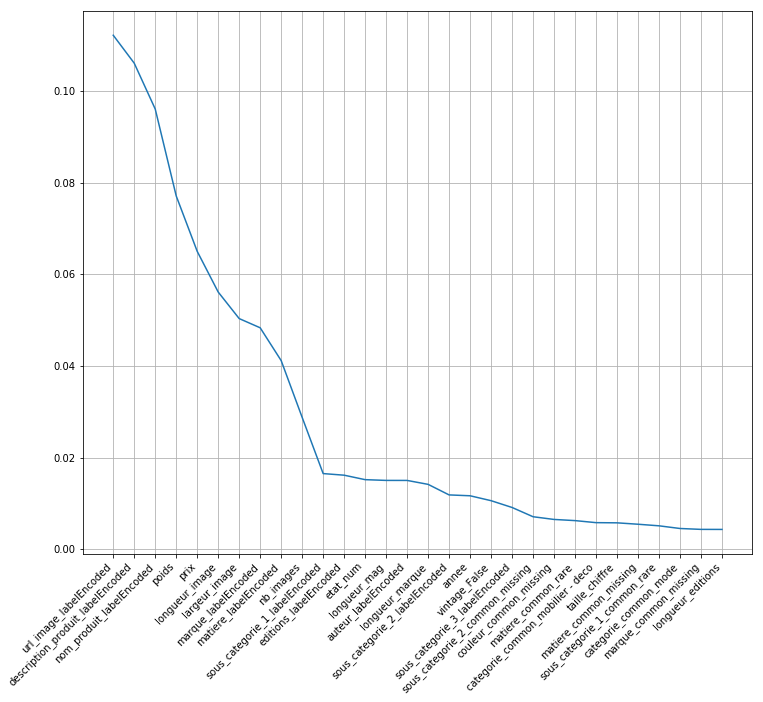

In [17]:
feature_importances = gb.feature_importances_
coefs = {k[0]:k[1] for k in zip(features_used, feature_importances)}
sorted_coefs = sorted(coefs.items(), key=operator.itemgetter(1), reverse = True)
top = 30
plt.plot(range(len(sorted_coefs[:top])), [a[1] for a in sorted_coefs[:top]])
plt.xticks(range(len(sorted_coefs[:top])), 
           [a[0].decode('utf-8') for a in sorted_coefs[:top]], 
           rotation =45,
           ha ='right')
plt.grid()
figure = plt.gcf() # get current figure
figure.set_size_inches(12, 10)

When you train the model on the entire training set, you obtain a lower log-loss, and that's what finally allowed to cross just below 0.9.
To conclude, there are things to do to still improve this model, especially with the scarce variables.